In [284]:
import warnings
warnings.filterwarnings("ignore")

In [285]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from tqdm import tqdm 
import datetime

In [286]:
factor_path = "/Users/shezihua/Documents/MAFM/2022-2023 Summer/MAFS 6100L/SummerIndependentProject/factor/"

futureCodeList = ['JBF', 'QWF', 'HCF', 'DBF', 'EHF', 'IPF', 'IIF', 'QXF', 'PEF', 'NAF']
stockCodeList = ['3443', '2388', '2498', '2610', '1319', '3035', '3006', '2615', '5425', '3105']

data_clean_path = '/Users/shezihua/Documents/MAFM/2022-2023 Summer/MAFS 6100L/SummerIndependentProject/dataCleaned/'

In [287]:
futureCode = futureCodeList[0]
stockCode = stockCodeList[0]

In [288]:
stock = pd.read_csv(data_clean_path + futureCode + "-" + stockCode + "/stock.csv.gz", compression='gzip', index_col=0)
future = pd.read_csv(data_clean_path + futureCode + "-" + stockCode + "/future.csv.gz", compression='gzip', index_col=0)
spread = np.log(stock['price']) - np.log(future['midQ'])
spread = pd.DataFrame(spread)
spread.columns = ['spread']

In [409]:
pool = pd.DataFrame()
pool.index = stock.index
pool['SP1'] = stock['SP1']
pool['BP1'] = stock['BP1']
pool['askPrice1'] = future['askPrice1']
pool['bidPrice1'] = future['bidPrice1']
pool['spread'] = spread['spread']
pool.index = pd.to_datetime(pool.index)

In [323]:
pool

,SP1,BP1,askPrice1,bidPrice1,spread
2020-07-01 09:00:02.246,25600.0,25550.0,25500,25350,0.005882
2020-07-01 09:00:03.690,25600.0,25550.0,25600,25450,0.001957
2020-07-01 09:01:01.824,25700.0,25650.0,25700,25600,0.000974
2020-07-01 09:01:19.564,25700.0,25600.0,25700,25600,0.000000
2020-07-01 09:01:40.888,25700.0,25650.0,25750,25650,-0.000973
...,...,...,...,...,...
2023-06-30 13:24:55.581,161000.0,160500.0,162000,161500,-0.006202
2023-06-30 13:24:55.900,161000.0,160500.0,162000,161500,-0.006202
2023-06-30 13:24:56.155,161000.0,160500.0,162000,161500,-0.006202
2023-06-30 13:24:57.846,161000.0,160500.0,162000,161500,-0.006202


In [410]:
trade = pd.DataFrame()
trade.index = pool.index
trade['spread'] = pool['spread']
trade['signal'] = 0
trade['cap'] = 0
trade['pnl'] = 0
trade.index = pd.to_datetime(trade.index)

In [325]:
trade

,spread,signal,cap,pnl
2020-07-01 09:00:02.246,0.005882,0,0,0
2020-07-01 09:00:03.690,0.001957,0,0,0
2020-07-01 09:01:01.824,0.000974,0,0,0
2020-07-01 09:01:19.564,0.000000,0,0,0
2020-07-01 09:01:40.888,-0.000973,0,0,0
...,...,...,...,...
2023-06-30 13:24:55.581,-0.006202,0,0,0
2023-06-30 13:24:55.900,-0.006202,0,0,0
2023-06-30 13:24:56.155,-0.006202,0,0,0
2023-06-30 13:24:57.846,-0.006202,0,0,0


In [141]:
del stock
del future
del spread

In [305]:
day_list = np.unique(pool.index.date)
train_period = 3

In [306]:
i = 0
train_start_time = trade.index >= pd.to_datetime(str(day_list[i]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
train_end_time = trade.index <= pd.to_datetime(str(day_list[i + train_period - 1]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
train = trade[train_start_time & train_end_time]
test_start_time = trade.index >= pd.to_datetime(str(day_list[i + train_period]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
test_end_time = trade.index <= pd.to_datetime(str(day_list[i + train_period]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
test = trade[test_start_time & test_end_time]

current_pool = pool[test_start_time & test_end_time]

mean = np.mean(train['spread'])
std = np.std(train['spread'])

upper = mean + 1.5 * std
lower = mean - 1.5 * std

In [311]:
for tick_idx in tqdm(range(len(test.index))): 
    current_data = test[0:tick_idx + 1]

    # long spread
    if test.loc[test.index[tick_idx]]['spread'] <= lower: 
        if np.sum(current_data['signal']) == 0: 
            test.at[test.index[tick_idx], 'signal'] = 1
            test.at[test.index[tick_idx], 'cap'] = - current_pool.iloc[tick_idx]['SP1'] * 2 + current_pool.iloc[tick_idx]['bidPrice1']

    # back to mean
    if test.loc[test.index[tick_idx]]['spread'] >= mean: 
        if np.sum(current_data['signal']) == 1: 
            test.at[test.index[tick_idx], 'signal'] = -1
            test.at[test.index[tick_idx], 'cap'] = current_pool.iloc[tick_idx]['BP1'] * 2 - current_pool.iloc[tick_idx]['askPrice1']
            test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) 

    # short spread
    if test.loc[test.index[tick_idx]]['spread'] >= upper: 
        if np.sum(current_data['signal']) == 0: 
            test.at[test.index[tick_idx], 'signal'] = -1
            test.at[test.index[tick_idx], 'cap'] = current_pool.iloc[tick_idx]['BP1'] * 2 - current_pool.iloc[tick_idx]['askPrice1']

    # back to mean 
    if test.loc[test.index[tick_idx]]['spread'] <= mean: 
        if np.sum(current_data['signal']) == -1: 
            test.at[test.index[tick_idx], 'signal'] = 1
            test.at[test.index[tick_idx], 'cap'] = - current_pool.iloc[tick_idx]['SP1'] * 2 + current_pool.iloc[tick_idx]['bidPrice1']
            test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap'])
    
    if tick_idx == len(test.index) - 1:
        if np.sum(current_data['signal']) == 1: 
            test.at[test.index[tick_idx], 'signal'] = -1
            test.at[test.index[tick_idx], 'cap'] = current_pool.iloc[tick_idx]['BP1'] * 2 - current_pool.iloc[tick_idx]['askPrice1']
            test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) 
        if np.sum(current_data['signal']) == -1: 
            test.at[test.index[tick_idx], 'signal'] = 1
            test.at[test.index[tick_idx], 'cap'] = - current_pool.iloc[tick_idx]['SP1'] * 2 + current_pool.iloc[tick_idx]['bidPrice1']
            test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) 

100%|██████████| 695/695 [00:00<00:00, 2369.49it/s]


In [378]:
day_list = np.unique(pool.index.date)
train_period = 3

for i in tqdm(range(len(day_list) - train_period)[-3:]):

    train_start_time = trade.index >= pd.to_datetime(str(day_list[i]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    train_end_time = trade.index <= pd.to_datetime(str(day_list[i + train_period - 1]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    train = trade[train_start_time & train_end_time]
    test_start_time = trade.index >= pd.to_datetime(str(day_list[i + train_period]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    test_end_time = trade.index <= pd.to_datetime(str(day_list[i + train_period]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    test = trade[test_start_time & test_end_time]

    current_pool = pool[test_start_time & test_end_time]

    mean = np.mean(train['spread'])
    std = np.std(train['spread'])

    upper = mean + 1.5 * std
    lower = mean - 1.5 * std

    for tick_idx in (range(len(test.index))): 
        current_data = test[0:tick_idx + 1]

        if tick_idx != len(test.index) - 1:
            # long spread
            if test.loc[test.index[tick_idx]]['spread'] <= lower: 
                if np.sum(current_data['signal']) == 0: 
                    trade.at[test.index[tick_idx], 'signal'] = 1
                    trade.at[test.index[tick_idx], 'cap'] = - current_pool.iloc[tick_idx]['SP1'] * 2 + current_pool.iloc[tick_idx]['bidPrice1']

            # back to mean
            elif test.loc[test.index[tick_idx]]['spread'] >= mean: 
                if np.sum(current_data['signal']) == 1: 
                    trade.at[test.index[tick_idx], 'signal'] = -1
                    trade.at[test.index[tick_idx], 'cap'] = current_pool.iloc[tick_idx]['BP1'] * 2 - current_pool.iloc[tick_idx]['askPrice1']
                    trade.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) 

            # short spread
            elif test.loc[test.index[tick_idx]]['spread'] >= upper: 
                if np.sum(current_data['signal']) == 0: 
                    trade.at[test.index[tick_idx], 'signal'] = -1
                    trade.at[test.index[tick_idx], 'cap'] = current_pool.iloc[tick_idx]['BP1'] * 2 - current_pool.iloc[tick_idx]['askPrice1']

            # back to mean 
            elif test.loc[test.index[tick_idx]]['spread'] <= mean: 
                if np.sum(current_data['signal']) == -1: 
                    trade.at[test.index[tick_idx], 'signal'] = 1
                    trade.at[test.index[tick_idx], 'cap'] = - current_pool.iloc[tick_idx]['SP1'] * 2 + current_pool.iloc[tick_idx]['bidPrice1']
                    trade.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap'])

            else: 
                pass
        
        else:
            if np.sum(current_data['signal']) == 1: 
                trade.at[test.index[tick_idx], 'signal'] = -1
                trade.at[test.index[tick_idx], 'cap'] = current_pool.iloc[tick_idx]['BP1'] * 2 - current_pool.iloc[tick_idx]['askPrice1']
                trade.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) 
            elif np.sum(current_data['signal']) == -1: 
                trade.at[test.index[tick_idx], 'signal'] = 1
                trade.at[test.index[tick_idx], 'cap'] = - current_pool.iloc[tick_idx]['SP1'] * 2 + current_pool.iloc[tick_idx]['bidPrice1']
                trade.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) 
            else:
                pass


100%|██████████| 3/3 [00:15<00:00,  5.02s/it]


In [411]:
PnL = np.array([0])

for i in tqdm(range(len(day_list) - train_period)[-60:]):
    train_start_time = trade.index >= pd.to_datetime(str(day_list[i]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    train_end_time = trade.index <= pd.to_datetime(str(day_list[i + train_period - 1]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    train = trade[train_start_time & train_end_time]
    test_start_time = trade.index >= pd.to_datetime(str(day_list[i + train_period]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    test_end_time = trade.index <= pd.to_datetime(str(day_list[i + train_period]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    test = trade[test_start_time & test_end_time]

    current_pool = pool[test_start_time & test_end_time]

    mean = np.mean(train['spread'])
    std = np.std(train['spread'])

    upper = mean + 1.5 * std
    lower = mean - 1.5 * std

    for tick_idx in (range(len(test.index))): 
        current_data = test[0:tick_idx + 1]

        if tick_idx != len(test.index) - 1:
            # long spread
            if test.loc[test.index[tick_idx]]['spread'] <= lower: 
                if np.sum(current_data['signal']) == 0: 
                    test.at[test.index[tick_idx], 'signal'] = 1
                    test.at[test.index[tick_idx], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']

            # back to mean
            elif test.loc[test.index[tick_idx]]['spread'] >= mean: 
                if np.sum(current_data['signal']) == 1: 
                    test.at[test.index[tick_idx], 'signal'] = -1
                    test.at[test.index[tick_idx], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
                    test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']

            # short spread
            elif test.loc[test.index[tick_idx]]['spread'] >= upper: 
                if np.sum(current_data['signal']) == 0: 
                    test.at[test.index[tick_idx], 'signal'] = -1
                    test.at[test.index[tick_idx], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']

            # back to mean 
            elif test.loc[test.index[tick_idx]]['spread'] <= mean: 
                if np.sum(current_data['signal']) == -1: 
                    test.at[test.index[tick_idx], 'signal'] = 1
                    test.at[test.index[tick_idx], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
                    test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap'])# + trade.loc[test.index[tick_idx]]['cap']

            else: 
                pass
        
        else:
            if np.sum(current_data['signal']) == 1: 
                test.at[test.index[tick_idx], 'signal'] = -1
                test.at[test.index[tick_idx], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
                test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']
            elif np.sum(current_data['signal']) == -1: 
                test.at[test.index[tick_idx], 'signal'] = 1
                test.at[test.index[tick_idx], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
                test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']
            else:
                pass
    
    
    PnL = np.append(PnL, test[test['pnl'] != 0]['pnl'] + PnL[-1])

100%|██████████| 60/60 [05:04<00:00,  5.07s/it]


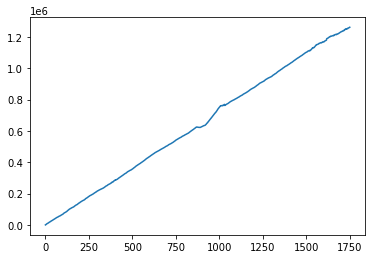

In [412]:
plt.plot(PnL)